In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
from pathlib import Path

In [1]:
%ls ../../../data/27_07_results_and_figures/final_results/



26-07-final-results.csv       final_results_d2_0.05_1.pdf
final_results_d1_0.05_0.pdf   final_results_d3_0.05_1.html
final_results_d1_0.05_1.html  final_results_d3_0.05_1.pdf
final_results_d1_0.05_1.pdf   final_results_d4_0.05_1.html
final_results_d2_0.05_1.html  final_results_d4_0.05_1.pdf


In [8]:
# Getting annotations ... -> not ideal needs to be refactores

# Todo: move file directories to config files, so that can be re-run with different counts


def load_files(samples, results_dir):
    df_list = []
    cntrl_list = []
    for sample in samples:
        df_list.append(pd.read_csv(Path(results_dir)/sample/"merged_counts.csv", index_col=0))
        cntrl_list.append(pd.read_csv(Path(results_dir)/sample/"merged_controls.csv", index_col=0))
    return pd.concat([pd.concat(df_list), pd.concat(cntrl_list)])


counts_dir ="/Users/ansintsova/git_repos/nguyenb_tnseq/data/13_04_results/counts"
outdir = '/Users/ansintsova/git_repos/nguyenb_tnseq/data/07_06_results/'
control_file = Path("/Users/ansintsova/git_repos/nguyenb_tnseq/data/13_04_results")/'controls.txt'

# Load
dnaids = ['dnaid1315', 'dnaid1428', 'dnaid1429', 'dnaid1457', 'dnaid2015', 'dnaid2016', 'dnaid2017', 'dnaid2018', 'dnaid2019',
         'dnaid2023', 'dnaid2024', 'dnaid2025', 'dnaid2026', 'dnaid2027', 'dnaid2028', 'dnaid2029' ]

cnt_df = load_files(dnaids, Path(counts_dir))
# Create unique identifier for each sample
cnt_df['sampleID'] = cnt_df['sampleID'] + "_" + cnt_df['dnaid'] + "_" + cnt_df['experiment']
cnt_df = cnt_df[cnt_df.sampleID.notnull()]
cnt_df['CntrlName'] = cnt_df['phenotype'] + cnt_df['conc'].astype(str)
cnt_df['ShortName'] = cnt_df.ShortName.fillna(cnt_df.CntrlName)

# Dropping Unenriched samples
cnt_df = cnt_df[~cnt_df.sampleID.str.contains('unenriched')]
annotation_df = cnt_df[['barcode', 'ShortName', 'locus_tag', 'phenotype', 'conc']].drop_duplicates()

libraries = [lib for lib in cnt_df.library.unique() if type(lib) == str]
libraries.remove('library_14_1')
print(len(libraries))
days = ['_d1', '_d2', '_d3', '_d4']




/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.



11


In [21]:
ann = cnt_df[['ShortName', 'locus_tag']].drop_duplicates()
#ann = ann[ann.ShortName]
ann = ann[ann.ShortName.apply(lambda x: len(x) < 10)]
ann.sample(25)

,ShortName,locus_tag
48,yfiA,SL1344_2624
891,cpxA,SL1344_4007
956,tktA,SL1344_3052
1131,yjcH,SL1344_4210
5085,ydiT,SL1344_1285
1165,treR,SL1344_4386
20,wcaF,SL1344_2087
774,pilM,SL1344_RS24640;old_SL1344_P2_0094
1006,csgG,SL1344_1076
18326,yebU,SL1344_1779


In [6]:
# Ranking should be done within each day, within each library, then take median rank for each gene
df = pd.read_csv("../../../data/27_07_results_and_figures/final_results/26-07-final-results.csv", index_col=0)
df['dir_change'] = df['z-score'].apply(lambda x: 1 if x > 0 else -1)
df.sample(5)

,gene,day,log2FC,lfcSE,lfc_pvalue,lfc_padj,z-score,CI,zscore_pval,zscore_padj,library
2088,rfbK,d3,-1.436787,0.508003,0.004680,0.044893,-2.709445,0.370170,0.006740,0.068145,library_10_2
4076,pgtP,d1,-0.163652,0.295492,0.579696,0.999108,-0.365373,0.923908,0.714833,0.997845,library_14_2
2728,hyb0.0005,d3,-2.384382,0.973504,0.014314,0.402436,-2.693513,0.152764,0.007070,0.196632,library_13_1
1689,SL1344_RS23770,d3,0.710609,0.270521,0.008619,0.068601,1.128200,1.275022,0.259235,0.555152,library_9_1
675,cadB,d1,-0.209595,0.413886,0.612570,0.995191,-0.518177,0.855412,0.604335,0.999790,library_10_2


In [28]:
# Read in final results table
#df = pd.read_csv("../../results/26-07-final-results.csv", index_col=0)
#df = pd.read_csv("../../../data/27_07_results_and_figures/final_results/26-07-final-results.csv", index_col=0)
# Rank all genes based on direction of change and adjusted p-value

df['dir_change'] = df['z-score'].apply(lambda x: 1 if x > 0 else -1)
df['rank'] = -1*np.log10(df['zscore_padj'])*df['dir_change']
df = df.merge(ann, how='left', left_on = 'gene', right_on ='ShortName').dropna()


In [59]:
df.sample(10).sort_values('rank', ascending=False)

,gene,day,log2FC,lfcSE,lfc_pvalue,lfc_padj,z-score,CI,zscore_pval,zscore_padj,library,dir_change,rank,ShortName,locus_tag
1701,mglC,d2,-0.154132,0.202385,0.446311,0.752251,1.741626,1.357600,0.081574,0.108256,library_11_1,1,0.965550,mglC,SL1344_2165
33931,sptP,d4,2.278636,0.603004,0.000158,0.001963,1.220034,1.732626,0.222452,0.291225,library_13_1,1,0.535771,sptP,SL1344_2858
19655,mppA,d3,0.636729,0.307556,0.038425,0.211014,0.630162,1.166251,0.528589,0.725221,library_11_2,1,0.139530,mppA,SL1344_1609
6232,yeeN,d1,0.798020,0.546022,0.143874,0.680058,1.238896,1.745667,0.215384,0.843795,library_15_1,1,0.073763,yeeN,SL1344_4429
36949,bapA,d2,0.332939,0.164184,0.042576,0.371902,1.120657,1.162638,0.262434,0.929924,library_14_2,1,0.031553,bapA,SL1344_2661
8122,phnU,d3,0.822090,0.793819,0.300382,0.994841,0.531156,1.357334,0.595311,0.965488,library_13_2,1,0.015253,phnU,SL1344_0421
22945,rmbA,d1,0.178660,0.437051,0.682697,0.997870,0.571605,1.199998,0.567589,0.998001,library_12_1,1,0.000869,rmbA,SL1344_3722
10471,ssaP,d4,0.447055,0.373020,0.230732,0.448300,-0.294005,0.921210,0.768754,0.877560,library_10_1,-1,-0.056723,ssaP,SL1344_1351
24969,argC,d3,-0.041887,0.215484,0.845873,0.931249,-2.086432,0.683917,0.036939,0.125616,library_12_1,-1,-0.900954,argC,SL1344_4071
34098,yhjS,d4,-0.143317,0.441039,0.745217,0.878873,-3.236464,0.323314,0.001210,0.004124,library_13_1,-1,-2.384733,yhjS,SL1344_3587


In [63]:
# Subset by days
df1 = df[df.day == 'd1']
# Calculate mean, median, min, max rank for each gene
ranked = df1.groupby('locus_tag').agg({'rank':['mean', 'median', 'min', 'max']}).dropna().reset_index()
ranked.columns = ['locus_tag', 'rank_mean', 'rank_median','rank_min', 'rank_max']

# Test these with fgsea

# Mean performed the best
ranked_mean = ranked[['locus_tag', 'rank_mean']]
ranked_mean.to_csv("./day1_ranked_mean.csv")



df2 = df[df.day == 'd2']

ranked = df2.groupby('locus_tag').agg({'rank':['mean', 'median', 'min', 'max']}).dropna().reset_index()
ranked.columns = ['locus_tag', 'rank_mean', 'rank_median','rank_min', 'rank_max']

ranked_mean = ranked[['locus_tag', 'rank_mean']]
ranked_mean.to_csv("./day2_ranked_mean.csv")


df3 = df[df.day == 'd3']

ranked = df3.groupby('locus_tag').agg({'rank':['mean', 'median', 'min', 'max']}).dropna().reset_index()
ranked.columns = ['locus_tag', 'rank_mean', 'rank_median','rank_min', 'rank_max']

ranked_mean = ranked[['locus_tag', 'rank_mean']]
ranked_mean.to_csv("./day3_ranked_mean.csv")



df4 = df[df.day == 'd4']

ranked = df4.groupby('locus_tag').agg({'rank':['mean', 'median', 'min', 'max']}).dropna().reset_index()
ranked.columns = ['locus_tag', 'rank_mean', 'rank_median','rank_min', 'rank_max']

ranked_mean = ranked[['locus_tag', 'rank_mean']]
ranked_mean.to_csv("./day4_ranked_mean.csv")

In [71]:
# For STRING get all the hits by day
# Day 1
print("\n".join(list(df[(df.zscore_padj < 0.05) & (df.day == 'd1')].gene.unique())))

STM3026
acrE
allP
amiC
anmK
argG
aroA
aroP
assT
avrA
bapA
bcsA
bigA
citA2
cpxA
csgB
csgG
cysG
dcoC
dgt
fadB
fadH
fepA
fidL
fimH
garD
garL
gcd
glpQ
glpT
gnd
gogB
gor
gpD
gpF
gtrAb
gtrBb
hsdS
hypD
idnK
invA
invC
invE
iolE
iolH
iolT1
katG
kdgT
kduD
lctP
lpfD
marT
metF
mglA
mgtB
mgtC
mgtR
nepI
nrfE
ompL
otsA
pduF
phoB
pipB2
prlC
psiF
ptr
pyrE
radC
rfaG
rfaI
rfaP
rfbH
rfbV
rhtB
rmbA
safA
sciH
sdaC
sgaB
siiC
siiF
sipC
sipD
slsA
sopB
sopD
spaO
speF
ssaU
sseK1
stbA
stbC
stcA
sthA
stjC
sxy
symE
tctD
tdcB
tdcD
traU
trmA
tyrB
udg
uvrD
virK
wcaD
wcaK
xylB
yaiB
ybbY
ybdO
ybdZ
ydiF
yeaJ
yeeN
yegO
yegT
yehE
yeiA
yfiN
ygaU
ygcY
yggB
ygjT
yhjS
yhjV
yiaB
yiaE
yiaL
yibD
yibK
yicE
yicL
yidA
yidZ
yieM
yihO
yihX
yiiG
yjeK
yjeM
yjfJ
yjfL
yjjI
yjjU
ykgB
ymbA
ytfG
acrB
hha
hybC
lpp
pstS
hypE
rfaB
rfbA
aroC
ccmF2
cpsB2
fdhD
hydA
iroN
mdoH
pefC
pmbA
proW
rfbC
rfbF
rfbI
rfbJ
rfbN
rfbU
rtsA
sgaH
siiB
siiE
spvA
spvB
spvR
sugR
sul2
torA
torD
traD
traE
traN
yafP
yggM
ygiK
yhhJ
yhjA
yiaM
yidE
yidH
yijF
acnB
adh
adiY
a

In [15]:
l102d1[['gene', 'z-score']].to_csv('../../results/25-08-l102d1-gene-zscore.csv', index=None)
# No enrichment detected
l102d1[['gene', 'log2FC']].to_csv('../../results/25-08-l102d1-gene-log2fc.csv', index=None)
# Nothing
#Try day 2
l102d2[['gene', 'z-score']].to_csv('../../results/25-08-l102d2-gene-zscore.csv', index=None)

In [69]:
# only hits
l102d1[l102d1.zscore_padj < 0.05][['gene']].to_csv('../../results/25-08-l102d1-gene-hits.csv', index=None, header=None)
# all hits
pd.Series(df1[df1.zscore_padj < 0.05].gene.unique()).to_csv('../../results/25-08-d1-gene-hits.csv', index=None, header=None)

In [32]:
genes = [g for g in df.gene if len(g) < 10]
# day 1
df1 = df[df.day == 'd1']
#Explore consitency in the resutls
#df1_exp = df1[df1.gene.isin(genes)].groupby(['gene']).agg({'z-score':['mean', 'std', 'median'], 'log2FC':['mean', 'std', 'median']}).dropna()
#df1_exp.columns = ['zscore_mean', 'zscore_std', 'zscore_median', 'fc_mean', 'fc_std', 'fc_median']

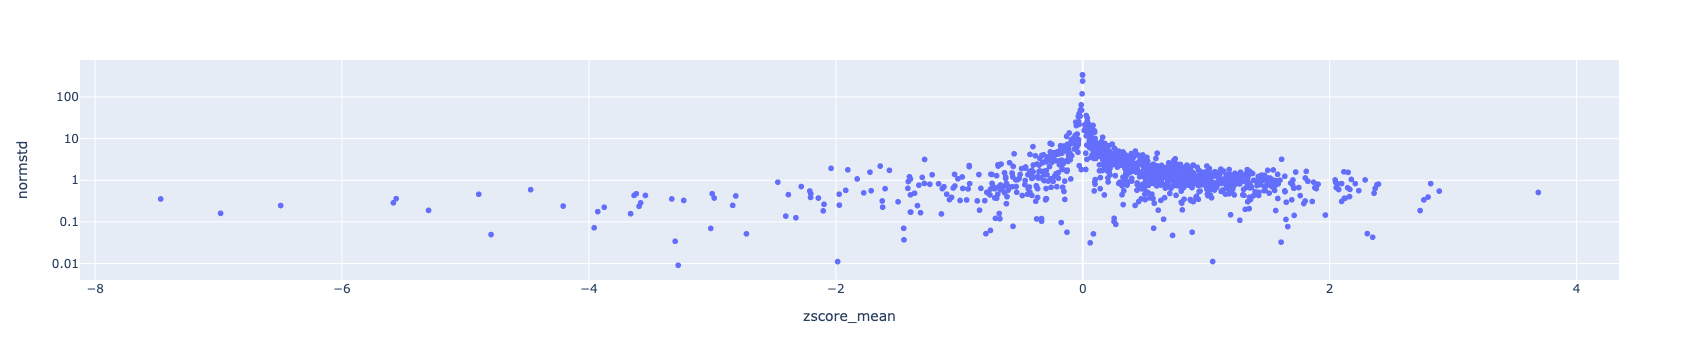

In [56]:
px.scatter(df1_exp, x="zscore_mean", y="normstd", log_y=True, hover_data=[df1_exp.index])

In [33]:
df1

,gene,day,log2FC,lfcSE,lfc_pvalue,lfc_padj,z-score,CI,zscore_pval,zscore_padj,library,dir_change,rank,ShortName,locus_tag
483,STM2208,d1,-0.058030,0.270035,0.829847,0.982528,1.347197,1.335691,0.177917,0.241630,library_11_1,1,0.616850,STM2208,SL1344_2185
484,STM3026,d1,0.316734,0.261272,0.225407,0.735491,2.620521,1.731892,0.008780,0.032363,library_11_1,1,1.489957,STM3026,SL1344_3005
535,acrB,d1,-0.081880,0.212604,0.700141,0.982528,1.505914,1.313791,0.132089,0.194192,library_11_1,1,0.711768,acrB,SL1344_0468
536,acrE,d1,0.073492,0.135587,0.587797,0.959138,2.694027,1.463181,0.007059,0.028182,library_11_1,1,1.550028,acrE,SL1344_3363
537,adiY,d1,0.277212,0.328332,0.398500,0.871282,2.080282,1.685092,0.037500,0.083609,library_11_1,1,1.077749,adiY,SL1344_4232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39711,ysaA,d1,0.826433,0.463590,0.074638,0.995191,1.680728,1.754086,0.092816,0.999790,library_10_2,1,0.000091,ysaA,SL1344_3631
39712,ytfF,d1,-0.066796,0.456000,0.883540,0.995191,-0.173677,0.944414,0.862119,0.999790,library_10_2,-1,-0.000091,ytfF,SL1344_4333
39713,ytfG,d1,-0.096825,0.381158,0.799474,0.995191,-0.278710,0.924959,0.780467,0.999790,library_10_2,-1,-0.000091,ytfG,SL1344_4334
39714,ytfJ,d1,0.085803,0.389561,0.825671,0.995191,0.170236,1.049782,0.864825,0.999790,library_10_2,1,0.000091,ytfJ,SL1344_4338


In [37]:
ranked = df1.groupby('locus_tag').agg({'rank':['mean', 'median', 'min', 'max', 'std']}).dropna().reset_index()
ranked.columns = ['locus_tag', 'rank_mean', 'rank_median','rank_min', 'rank_max', 'rank_std'
]

In [38]:
ranked.sort_values('rank_mean').head(40)

,locus_tag,rank_mean,rank_median,rank_min,rank_max,rank_std
831,SL1344_3688,-11.376263,-13.153502,-18.194556,-2.780730,7.859099
954,SL1344_4114,-9.087819,-10.307042,-11.149808,-5.806606,2.872687
819,SL1344_3671,-7.749186,-7.749186,-10.582658,-4.915713,4.007135
828,SL1344_3684,-5.866575,-4.768088,-15.383558,-0.486954,4.126538
772,SL1344_3562,-5.449985,-5.449985,-9.015146,-1.884825,5.041898
1025,SL1344_4350,-5.349233,-5.349233,-10.094996,-0.603470,6.711523
830,SL1344_3687,-4.926578,-5.495722,-7.432556,-2.976874,1.863965
275,SL1344_1311,-3.200556,-3.200556,-3.724168,-2.676943,0.740500
434,SL1344_2067,-2.741056,-2.411730,-4.758295,-0.434539,1.660010
436,SL1344_2069,-2.738203,-3.264337,-4.116479,-0.307658,1.703066


In [47]:
# Try with mean
ranked_mean = ranked[['locus_tag', 'rank_mean']]
ranked_mean.to_csv("./ranked_mean.csv")

ranked_median = ranked[['locus_tag', 'rank_median']]
ranked_median.to_csv("./ranked_median.csv")


ranked_median = ranked[['locus_tag', 'rank_min']]
ranked_median.to_csv("./ranked_min.csv")
# Try with median

# Try with max absolute rank for each gene


# MEAN MAKES MOST SENSE

In [69]:
df1[df1.gene == 'bapA']

,gene,day,log2FC,lfcSE,lfc_pvalue,lfc_padj,z-score,CI,zscore_pval,zscore_padj,library,dir_change,rank
556,bapA,d1,0.138065,0.142078,0.331173,0.827216,2.947572,1.530158,0.003203,0.017774,library_11_1,1,1.750220
2758,bapA,d1,-0.532159,0.867261,0.539473,0.897385,-0.562771,0.694285,0.573591,0.968906,library_15_1,-1,-0.013718
1925,bapA,d1,-0.027793,0.218651,0.898851,0.983367,1.472555,1.298383,0.140871,0.359163,library_10_1,1,0.444708
540,bapA,d1,0.141675,0.354654,0.689545,0.998294,0.621251,1.182734,0.534435,0.997992,library_11_2,1,0.000873
636,bapA,d1,-0.130052,0.684118,0.849229,0.999154,-0.315263,0.851140,0.752562,0.999535,library_12_2,-1,-0.000202
576,bapA,d1,0.130621,0.737189,0.859361,0.999990,0.029578,1.015947,0.976403,0.999942,library_13_1,1,0.000025
3891,bapA,d1,0.320994,0.161563,0.046944,0.668332,1.940599,1.292771,0.052307,0.840530,library_14_2,1,0.075447


In [43]:
ranked_mean

,locus_tag,rank_mean
0,SL1344_0005,0.063922
1,SL1344_0006,0.187702
2,SL1344_0018,0.372327
3,SL1344_0021,0.474989
4,SL1344_0022,0.005941
...,...,...
1125,SL1344_RS24645,0.151143
1126,SL1344_RS24690,-1.379057
1127,SL1344_RS26285,0.276558
1128,SL1344_RS26320,0.007548
